# Define the system  

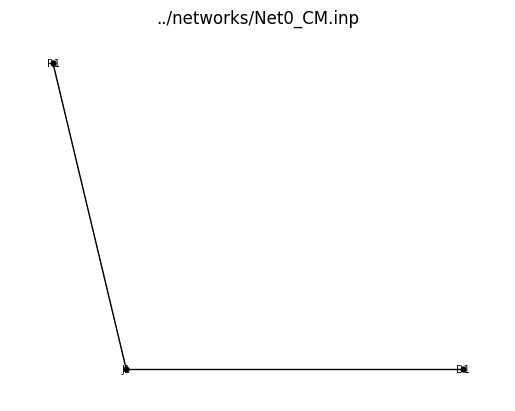

<Axes: title={'center': '../networks/Net0_CM.inp'}>

In [85]:
import wntr
import wntr_quantum

# Create a water network model
inp_file = '../networks/Net0_CM.inp'
# inp_file = '../networks/Net2LoopsCM.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)


## Expression of he network

In [86]:
from wntr_quantum.scenario.network_design_qubo import NetworkDesign
from qubols.solution_vector import SolutionVector_V2 as SolutionVector
from qubols.encodings import  RangedEfficientEncoding, PositiveQbitEncoding

flow_encoding = RangedEfficientEncoding(nqbit=7, range=2, offset=0, var_base_name="x")
head_encoding = RangedEfficientEncoding(nqbit=7, range=2, offset=0, var_base_name="x")


# pipe_diameters = [0.35, 0.4, 0.45, 0.55]
pipe_diameters = [2, 4]
designer = NetworkDesign(wn, flow_encoding=flow_encoding, 
                         head_encoding=head_encoding, 
                         pipe_diameters=pipe_diameters,
                         weight_cost=0.01)

/home/nico/QuantumApplicationLab/qubols/qubols/encodings.py:265: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coefs, res, rank, s = np.linalg.lstsq(A, self.discrete_values)


In [87]:
designer.matrices[0]

array([[0.5 ],
       [1.  ],
       [2.  ],
       [0.  ],
       [0.01]])

In [88]:
designer.enumerates_classical_solutions()

(0.25, 0.25) [1.5   1.    1.438 1.188]
(0.25, 0.5) [1.5   1.    1.438 0.938]
(0.5, 0.25) [1.5   1.    0.875 0.625]
(0.5, 0.5) [1.5   1.    0.875 0.375]


/home/nico/QuantumApplicationLab/QuantumNewtonRaphson/quantum_newton_raphson/utils.py:74: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn("spsolve requires A be CSC or CSR matrix format", SparseEfficiencyWarning)


In [89]:
designer.sol_vect_res.encoded_reals[0].get_possible_values()

[0.24999999999999992, 0.5]

In [90]:
from qubols.qubo_poly_mixed_variables import QUBO_POLY_MIXED
import sparse
qubo = QUBO_POLY_MIXED(designer.mixed_solution_vector)

In [91]:
matrices = tuple(sparse.COO(m) for m in designer.matrices)
bqm = qubo.create_bqm(matrices, strength=1000)

In [92]:
istart = designer.sol_vect_flows.size
for i in range(designer.sol_vect_heads.size):

    bqm.add_linear_inequality_constraint(
        qubo.all_expr[istart + i],
        lagrange_multiplier=1,
        label="head_%s" % i,
        lb=1,
        ub=2,
    )

/home/nico/miniconda3/envs/vitens_wntr_1/lib/python3.9/site-packages/dimod/binary/binary_quadratic_model.py:759: UserWarning: For constraints with fractional coefficients, multiply both sides of the inequality by an appropriate factor of ten to attain or approximate integer coefficients. 
  warnings.warn("For constraints with fractional coefficients, "


In [93]:
sampleset = qubo.sample_bqm(bqm, num_reads=10000)

In [94]:
flow, heads, param = qubo.decode_solution(sampleset.lowest())

In [95]:
flow, heads, param

([1.7142857142857142, 1.0476190476190474],
 [1.1111111111111112, 0.9206349206349206],
 [0.24999999999999992, 0.24999999999999992])

In [96]:
import numpy as np
num_heads = designer.wn.num_junctions
designer.verify_solution(np.array(flow+heads), param)

array([-0.167, -0.048,  0.154, -0.084])

In [97]:
sampleset.record[0]

([1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1], -2.78, 1)

In [116]:
nsol = []
cost = []
cons = []
colors = []
count = dict()
for i in range(10000):
    flow, heads, param = qubo.decode_solution(sampleset, sol_index=i)
    nsol.append(np.linalg.norm(designer.verify_solution(np.array(flow+heads), param)))
    cost.append(np.sum(param))
    cons.append(np.sum(np.array(heads)-1))
    if nsol[-1] < 1 and cons[-1] > 0:
        if tuple(param) not in count:
            count[tuple(param)] = 0
        count[tuple(param)] += 1
    



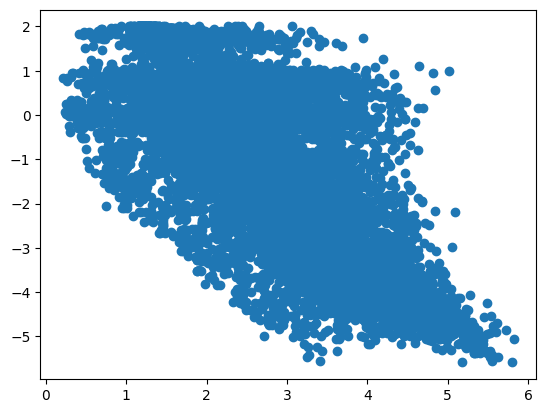

In [117]:
import matplotlib.pyplot as plt
plt.scatter(nsol, cons)

In [118]:
count

{(0.5, 0.5): 1200,
 (0.24999999999999992, 0.24999999999999992): 487,
 (0.24999999999999992, 0.5): 1354,
 (0.5, 0.24999999999999992): 435}

In [101]:
import dimod
cqm = dimod.ConstrainedQuadraticModel()

In [103]:
cqm.add_variable('REAL', 'x')
cqm.add_variable('REAL', 'y')

'y'

In [105]:
cqm.add_constraint('x+y<1',label='c0')

TypeError: add_constraint_from_iterable() missing 1 required positional argument: 'sense'

In [112]:
x, y = dimod.Integers(['x', 'y'])
cqm = dimod.ConstrainedQuadraticModel()
cqm.add_constraint(x + y + x*y <= 1, label='c0')

'c0'

In [113]:
cqm.constraints['c0'].to_polystring()

'x + y + x*y <= 1.0'